$(1,0)$
- Differences: $-127<x2<130, -132<x1<131$ (101 instances)
- RL: $-138<x2<146, -144<x1<142$
    - CF: $x2≤-128 \rightarrow (1,1)$
    - CF: $x2≥133 \rightarrow (1,1)$
    - CF: $x1≤-144 \rightarrow (1,1)$
    - CF: $x1≥135 \rightarrow (1,1)$
    - RLL: $-112<x1<106$ (50 instances different)
        - CF: $x1≤-122 \rightarrow (1,1)$
        - CF: $x1≥109 \rightarrow (1,1)$
    - RLRR: $-121<x1<112$ (51 instances different)
        - CF: $x2≤-104 \rightarrow (1,1)$
        - CF: $x2≥101 \rightarrow (1,1)$

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering
from tasks.gaussian_quantiles import make_task

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [4]:
xlim = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
ylim = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [6]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [5]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 601it [00:41, 12.49it/s]                         
Exact explainer: 601it [00:30, 13.35it/s]                         
Exact explainer: 601it [01:03,  7.80it/s]                         

CPU times: user 2min 5s, sys: 1.62 s, total: 2min 7s
Wall time: 2min 14s


# Traditional SHAP Explanations

In [7]:
with open('indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [8]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

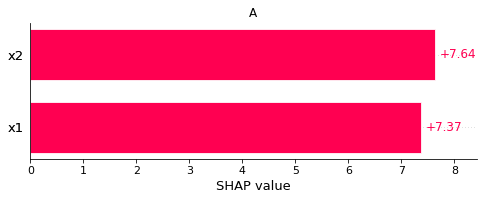

In [9]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

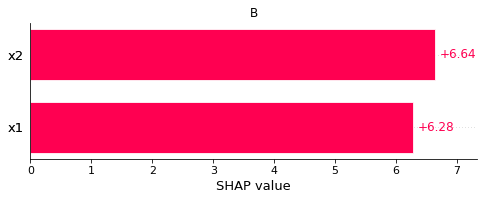

In [10]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [11]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 75.3 ms, sys: 5.26 ms, total: 80.6 ms
Wall time: 85.9 ms


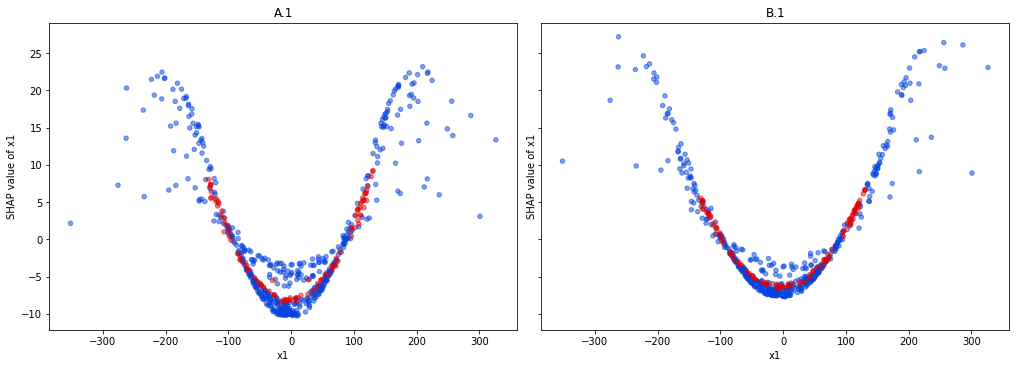

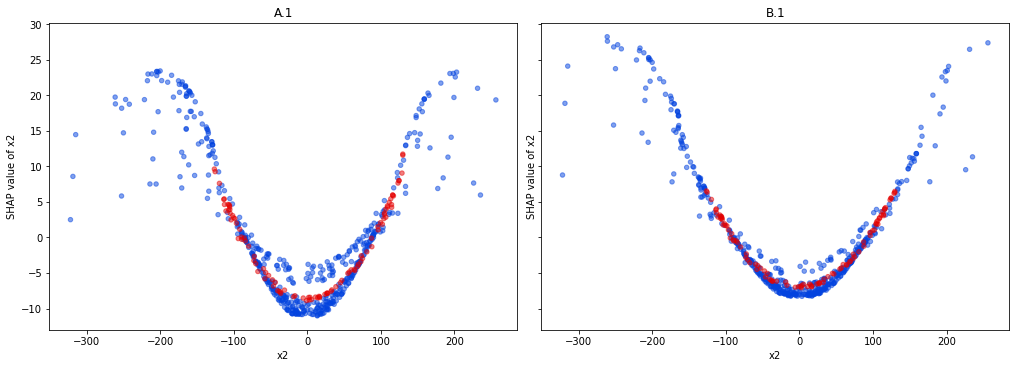

In [12]:
for feature in feature_names:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [13]:
with open('diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

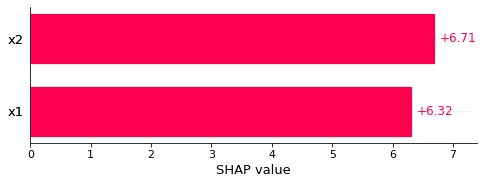

In [7]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

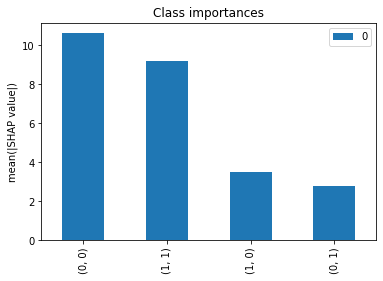

In [9]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

## Clustering of Class $(1,0)$ SHAP Values

In [10]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])
node.class_counts, node.distance

CPU times: user 158 ms, sys: 5.71 ms, total: 164 ms
Wall time: 165 ms


((0, 0)    259
 (1, 1)    240
 (1, 0)    101
 dtype: int64,
 7155.744603299222)

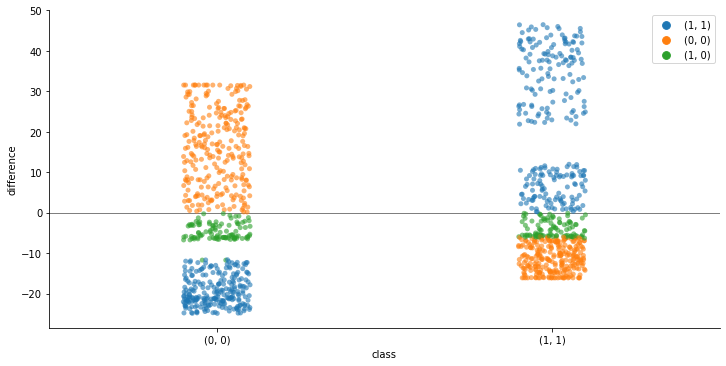

{'(0, 0)': '-11.73 to -0.23', '(1, 1)': '-6.29 to -0.15'}


In [17]:
node.plot_outcome_differences()

### Node RL

In [11]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RL,
 (0, 0)    259
 (1, 0)    101
 (1, 1)     54
 dtype: int64,
 2153.4121830001604)

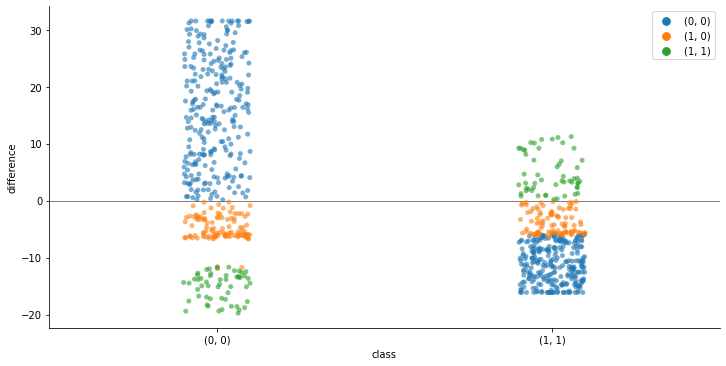

{'(0, 0)': '-11.73 to -0.23', '(1, 1)': '-6.29 to -0.15'}


In [19]:
node.plot_outcome_differences()

-131.33844202155564 <= x1 <= 130.61962226695064
x1 <= -144.0 --> {'(1, 1)': 101}
x1 >= 135.0 --> {'(1, 1)': 101}


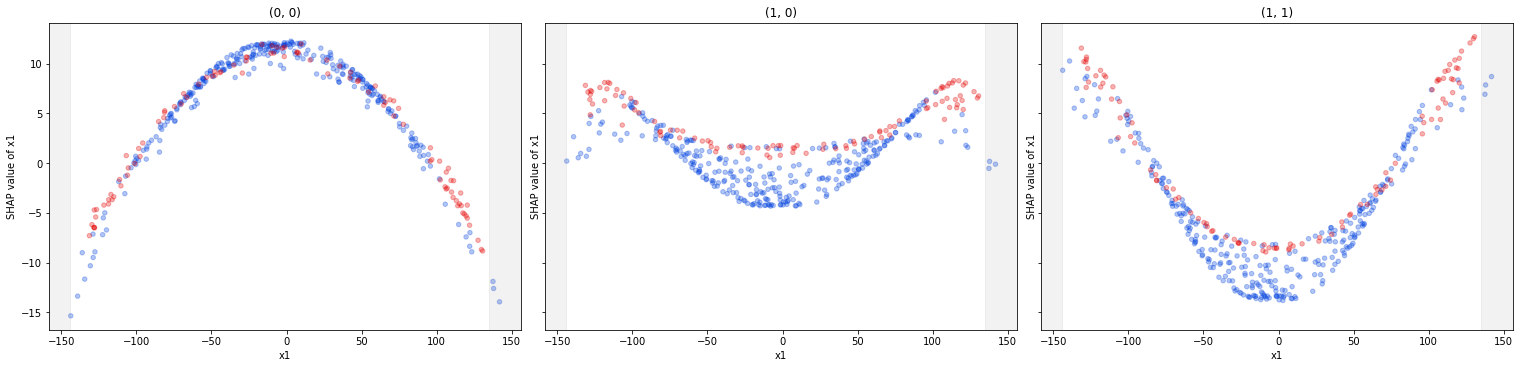

-126.41356491347094 <= x2 <= 129.7495758596666
x2 <= -128.0 --> {'(1, 1)': 101}
x2 >= 133.0 --> {'(1, 1)': 101}


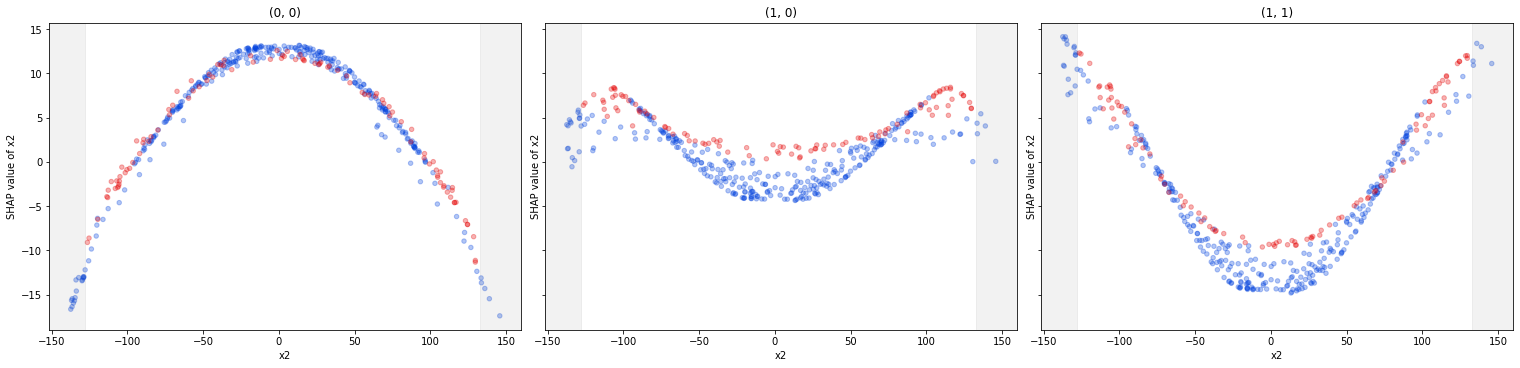

In [13]:
for feature in feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.plot_feature_dependence(feature, focus=node, alpha=0.3)

-131.33844202155564 <= x1 <= 130.61962226695064
x1 <= -144.0 --> {'(1, 1)': 101}
x1 >= 135.0 --> {'(1, 1)': 101}


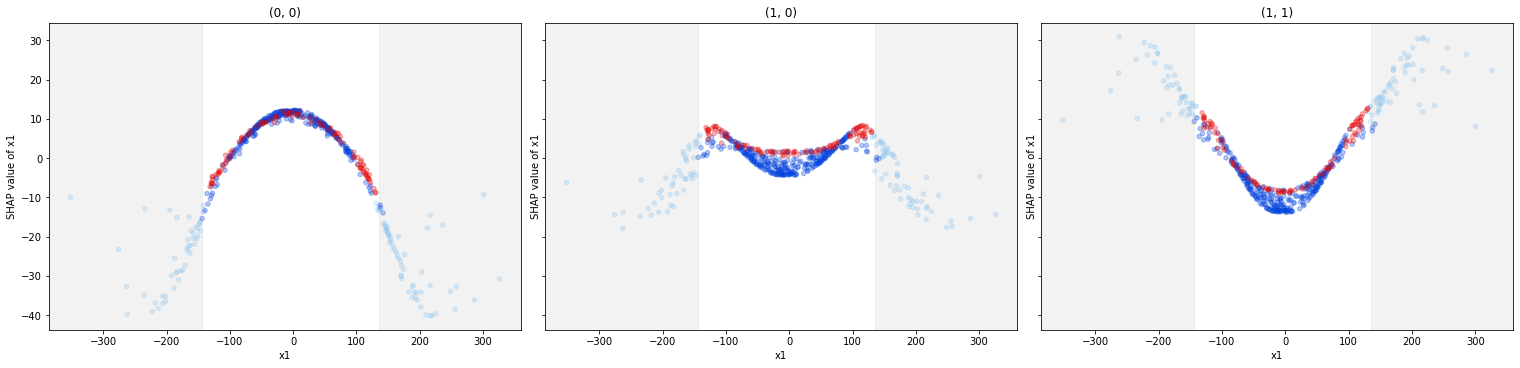

-126.41356491347094 <= x2 <= 129.7495758596666
x2 <= -128.0 --> {'(1, 1)': 101}
x2 >= 133.0 --> {'(1, 1)': 101}


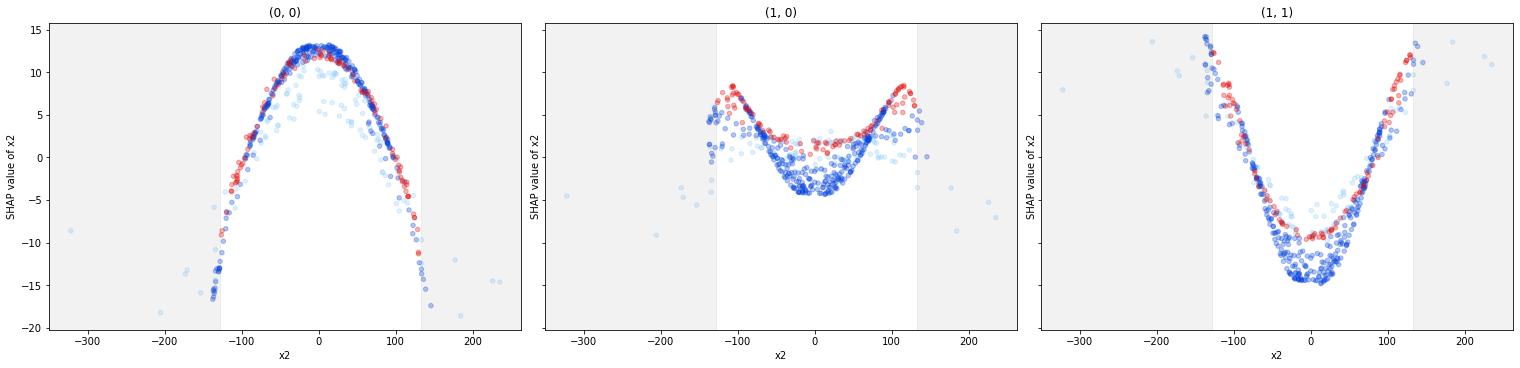

In [14]:
for feature in feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature_dependence(feature, focus=node, alpha=0.3)

-131.33844202155564 <= x1 <= 130.61962226695064
x1 <= -144.0 --> {'(1, 1)': 101}
x1 >= 135.0 --> {'(1, 1)': 101}


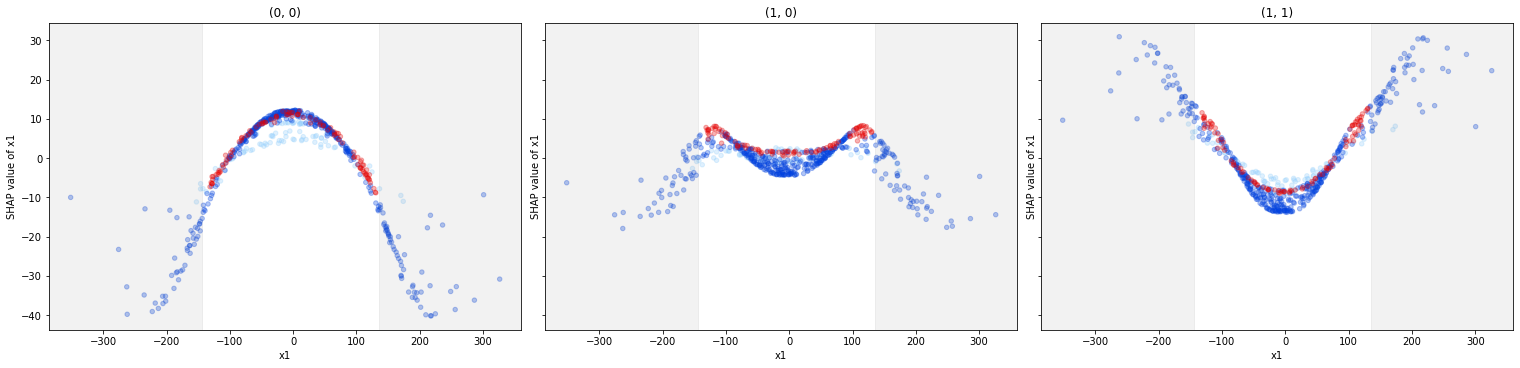

-126.41356491347094 <= x2 <= 129.7495758596666
x2 <= -128.0 --> {'(1, 1)': 101}
x2 >= 133.0 --> {'(1, 1)': 101}


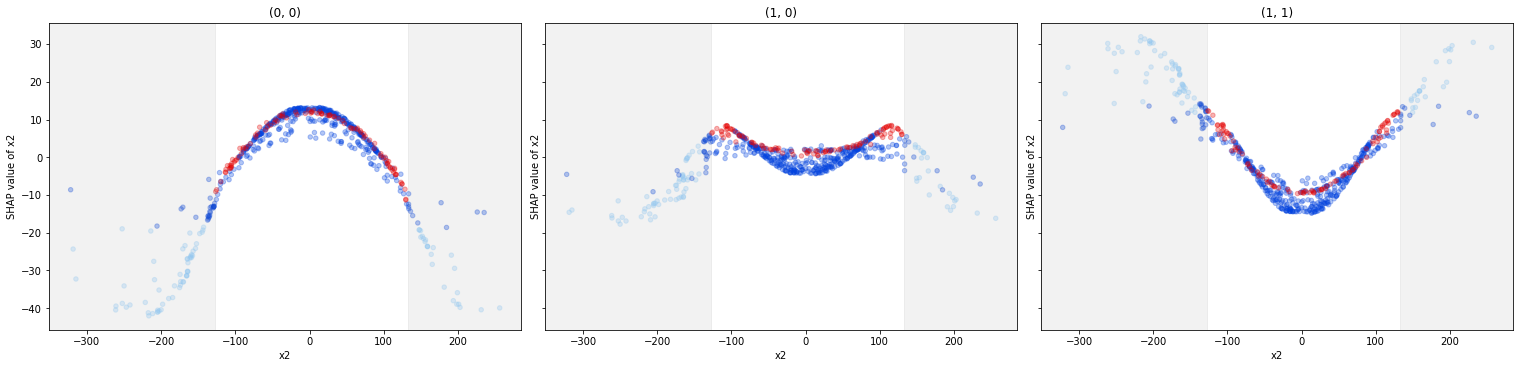

In [18]:
for feature in feature_names:
    node.parent.describe_feature_differences(feature)
    node.parent.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.parent, alpha=0.3)

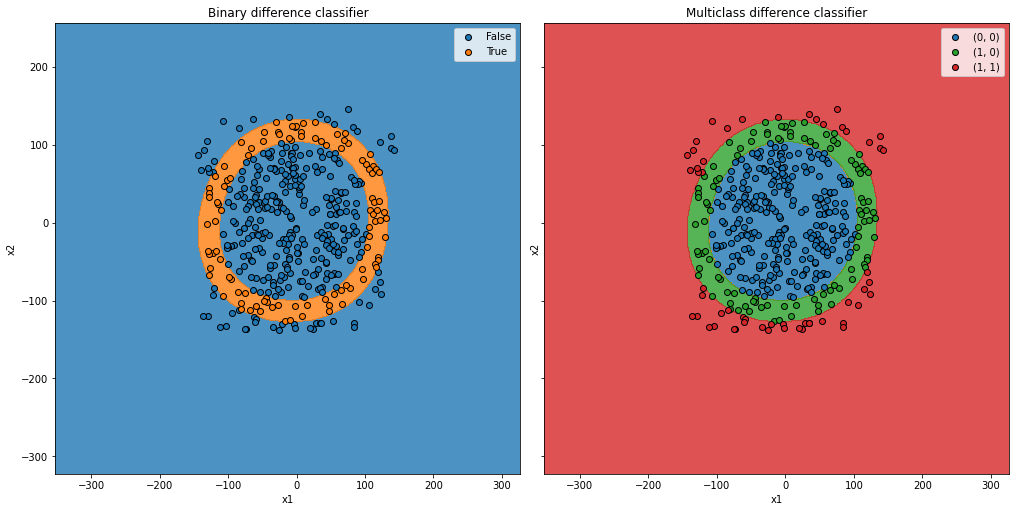

In [19]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

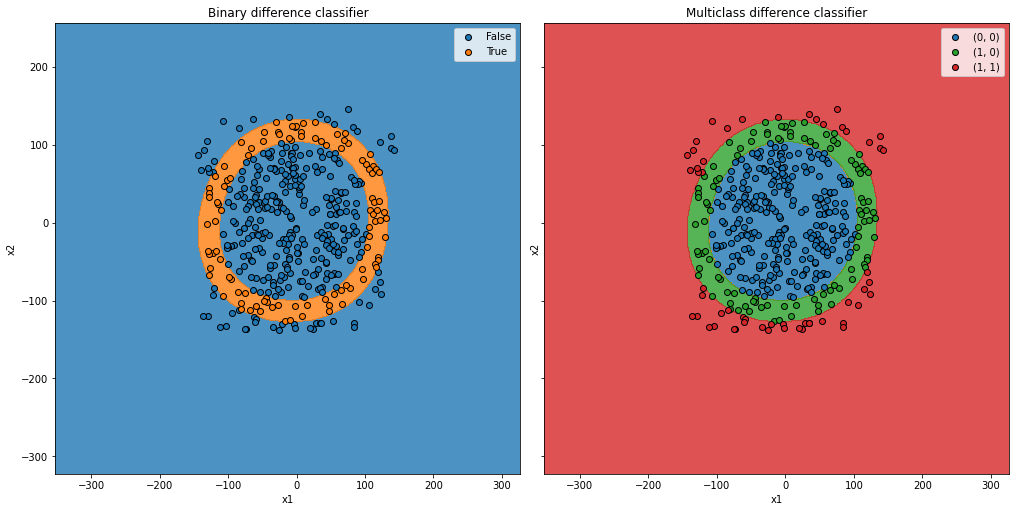

In [20]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

### Node RLL

In [12]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLL,
 (0, 0)    77
 (1, 0)    50
 (1, 1)    34
 dtype: int64,
 1008.5755069618963)

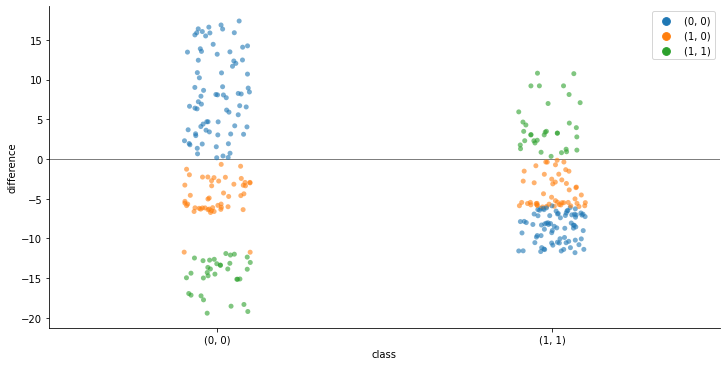

{'(0, 0)': '-11.73 to -0.67', '(1, 1)': '-6.04 to -0.16'}


In [21]:
node.plot_outcome_differences()

-85.21550165878162 <= x1 <= 77.85447754205681
x1 <= -122.0 --> {'(1, 1)': 50}
x1 >= 109.0 --> {'(1, 1)': 50}


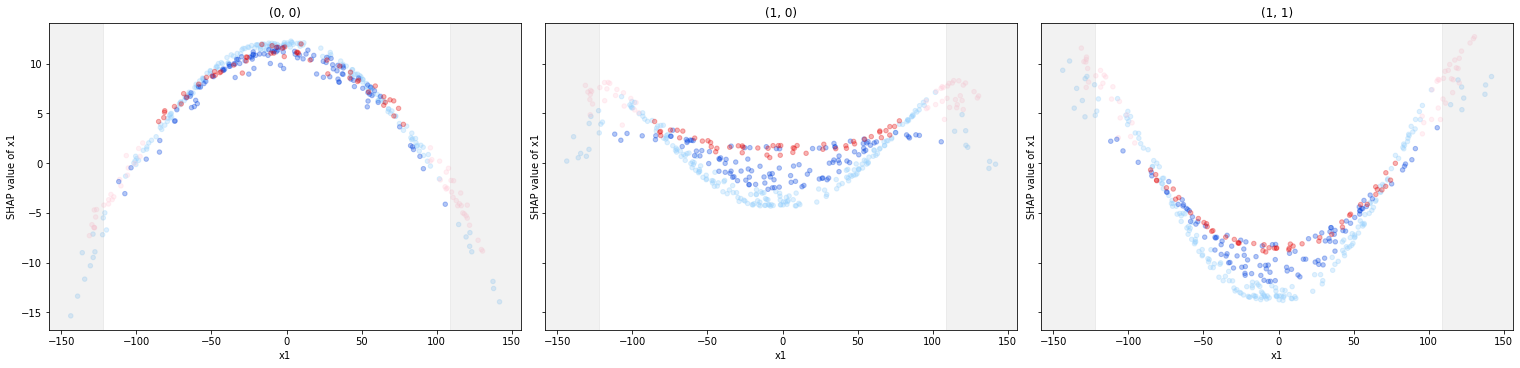

-126.41356491347094 <= x2 <= 129.7495758596666
x2 <= -128.0 --> {'(1, 1)': 50}
x2 >= 133.0 --> {'(1, 1)': 50}


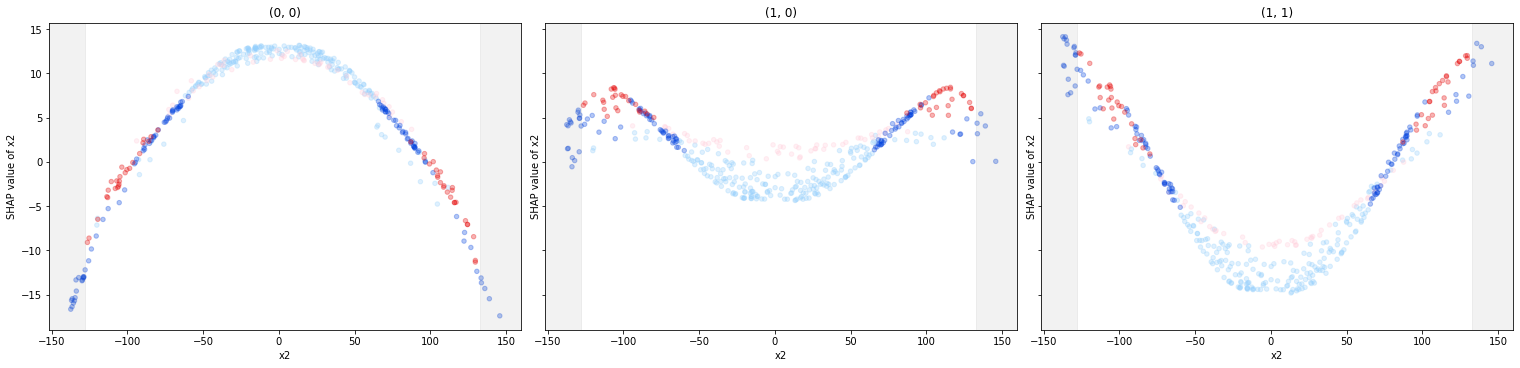

In [40]:
for feature in feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature_dependence(feature, focus=node, alpha=0.3)

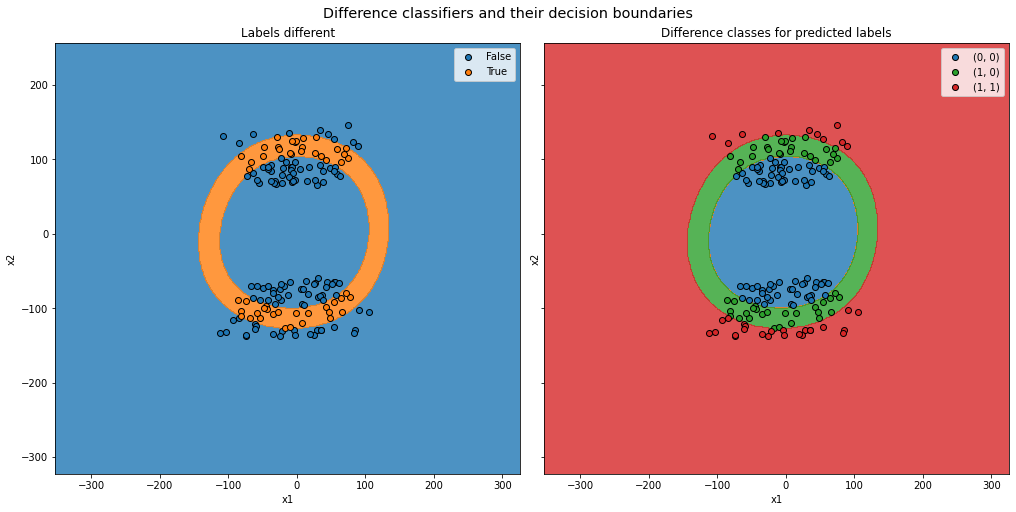

In [106]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

### Node RLLLR

In [13]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLLLR,
 (1, 0)    41
 (0, 0)    12
 dtype: int64,
 269.55779843029006)

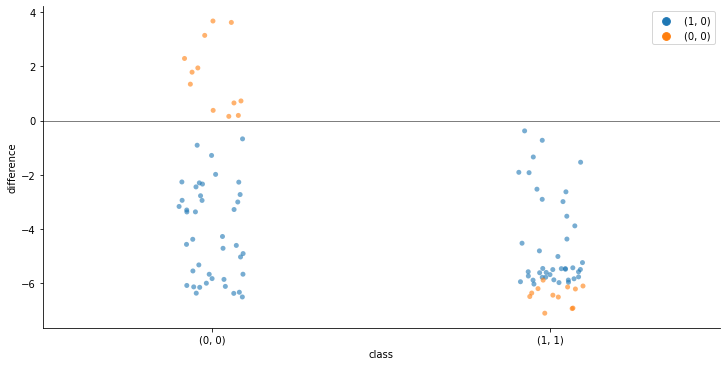

{'(0, 0)': '-6.51 to -0.67', '(1, 1)': '-6.04 to -0.38'}


In [23]:
node.plot_outcome_differences()

-85.21550165878162 <= x1 <= 77.85447754205681
x1 <= -122.0 --> {'(1, 1)': 41}
x1 >= 109.0 --> {'(1, 1)': 41}


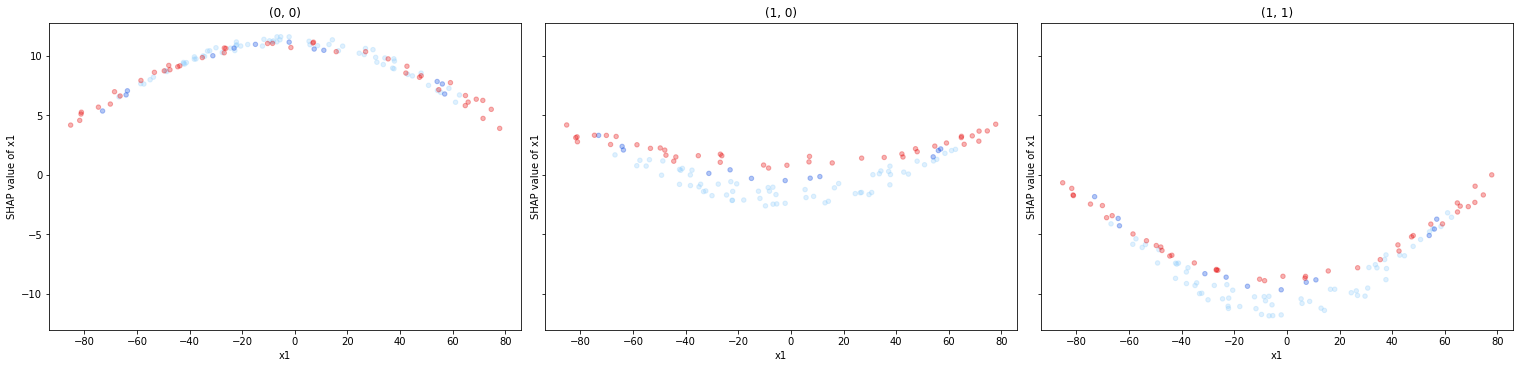

-113.56328621239042 <= x2 <= 117.02433684190137
x2 <= -128.0 --> {'(1, 1)': 41}
x2 >= 133.0 --> {'(1, 1)': 41}


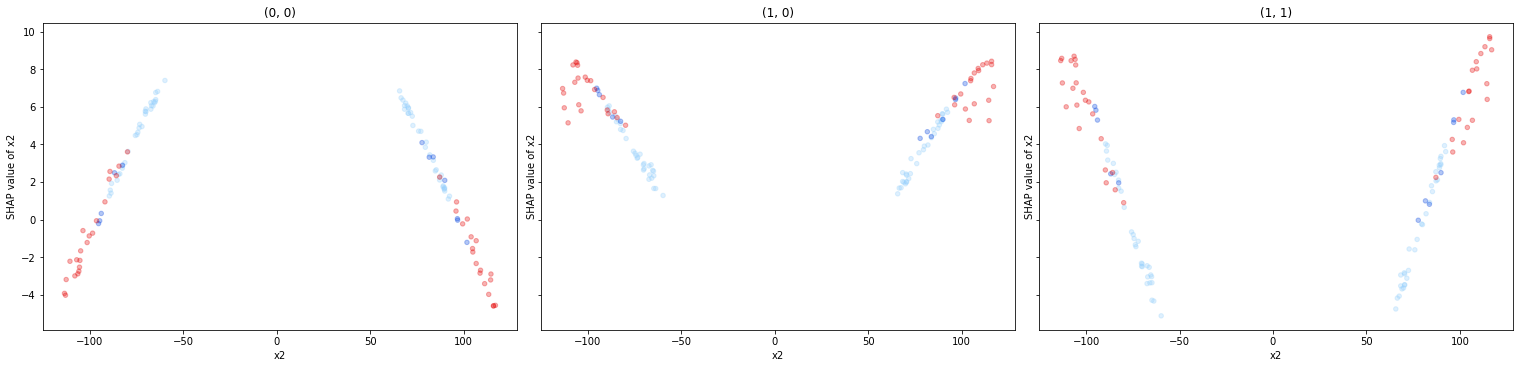

In [95]:
for feature in feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature_dependence(feature, focus=node, alpha=0.3)

-85.21550165878162 <= x1 <= 77.85447754205681
x1 <= -122.0 --> {'(1, 1)': 41}
x1 >= 109.0 --> {'(1, 1)': 41}


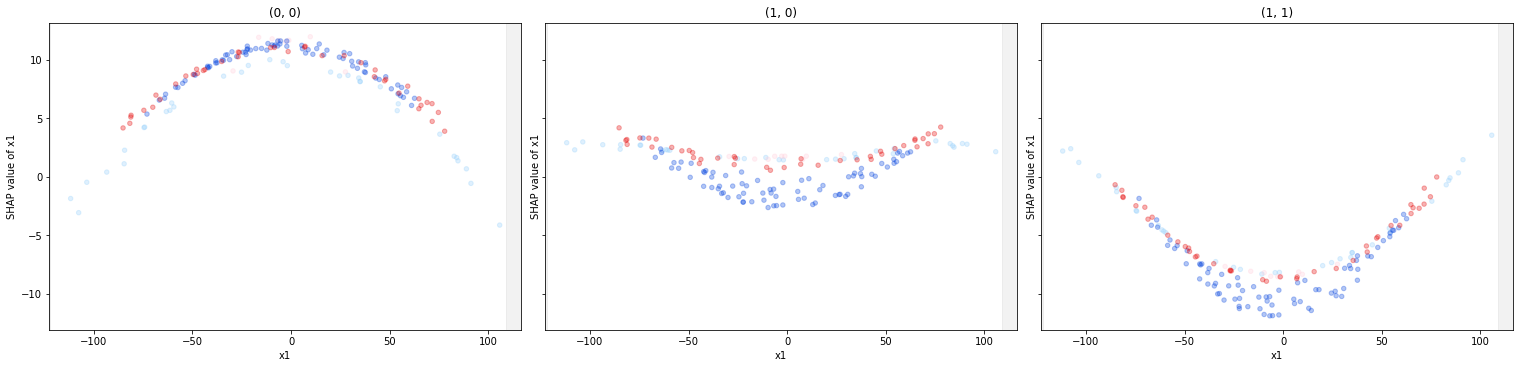

-113.56328621239042 <= x2 <= 117.02433684190137
x2 <= -128.0 --> {'(1, 1)': 41}
x2 >= 133.0 --> {'(1, 1)': 41}


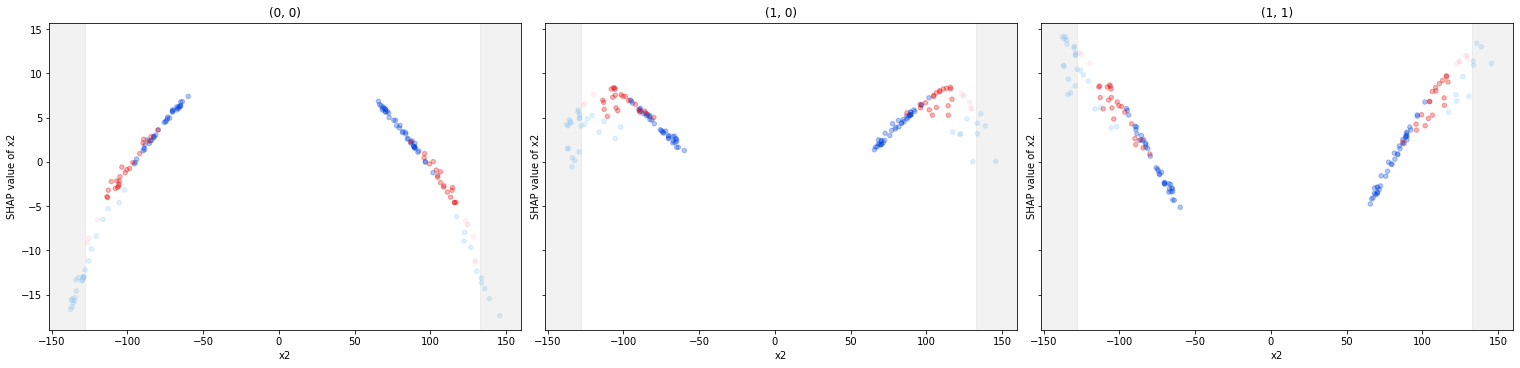

In [47]:
for feature in feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature_dependence(feature, focus=node.parent, alpha=0.3)

Comparing the next level's dependence plots to the previous, it's clear that the explanation doesn't get much better with deeper levels. I will go down the hierarchy more to demonstrate a weakness of this method.

But I can also manually create counterfactuals for instances where x2<0 and >=0:

In [23]:
part = node.filter(node.shap_values[:, 'x2'].data < 0)
for feature in feature_names:
    part.describe_feature_differences(feature)
    part.describe_counterfactuals(feature)

-85.21550165878162 <= x1 <= 77.85447754205681
x1 <= -122.0 --> {'(1, 1)': 22}
x1 >= 105.0 --> {'(1, 1)': 22}
-113.56328621239042 <= x2 <= -79.87248410506523
x2 <= -128.0 --> {'(1, 1)': 22}
x2 >= -67.0 --> {'(0, 0)': 22}


In [24]:
part = node.filter(node.shap_values[:, 'x2'].data >= 0)
for feature in feature_names:
    part.describe_feature_differences(feature)
    part.describe_counterfactuals(feature)

-81.76632338846144 <= x1 <= 74.6479354034524
x1 <= -106.0 --> {'(1, 1)': 19}
x1 >= 109.0 --> {'(1, 1)': 19}
87.1887706640731 <= x2 <= 117.02433684190137
x2 <= 69.0 --> {'(0, 0)': 19}
x2 >= 133.0 --> {'(1, 1)': 19}


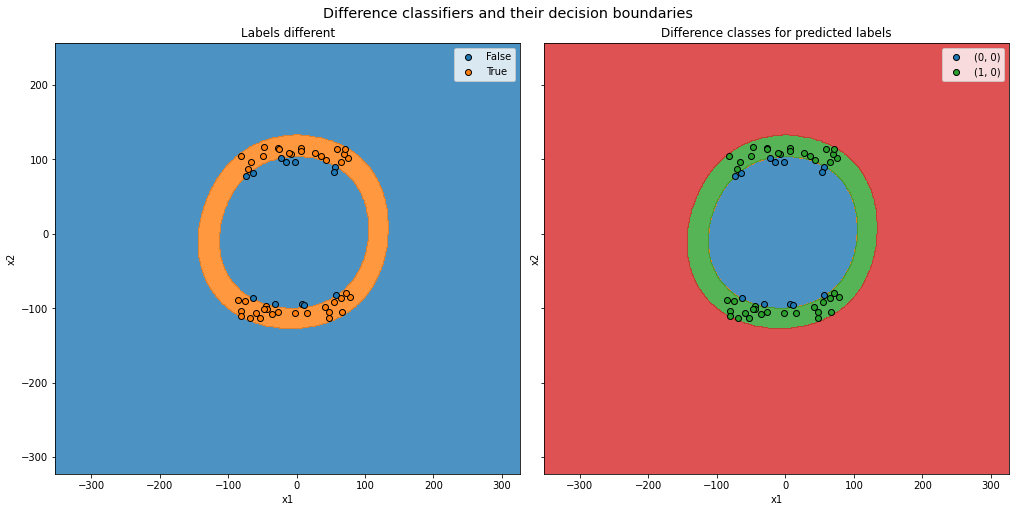

In [48]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

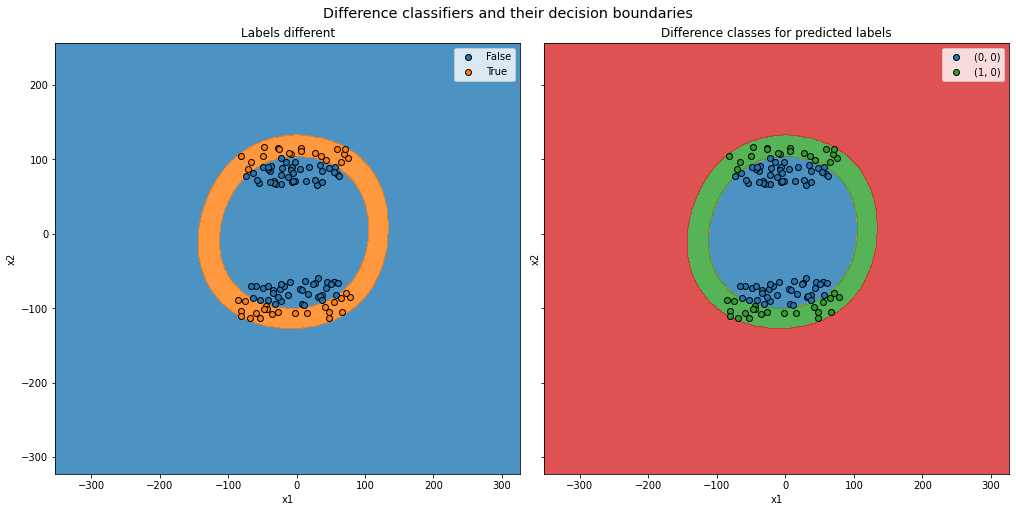

In [49]:
comparer.plot_decision_boundaries(node.parent.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

In [75]:
node = node.get_left()
node.class_counts, node.distance

((1, 0)    25
 (0, 0)     6
 dtype: int64,
 78.69103166227512)

-68.53396982691486 <= x1 <= 59.13543068040621
x1 <= -105.0 --> {'(1, 1)': 25}
x1 >= 97.0 --> {'(1, 1)': 25}


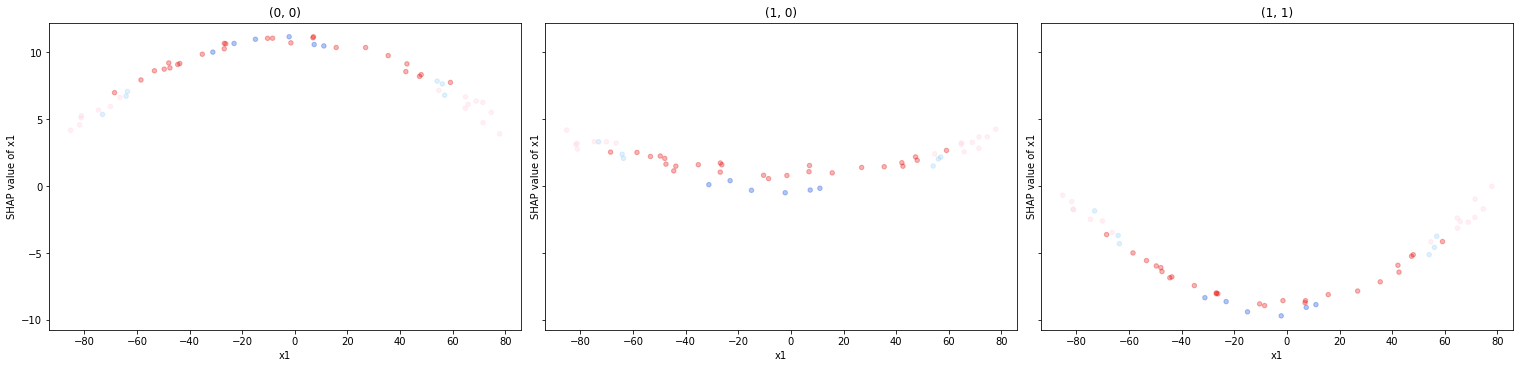

-113.56328621239042 <= x2 <= 117.02433684190137
x2 <= -128.0 --> {'(1, 1)': 25}
x2 >= 133.0 --> {'(1, 1)': 25}


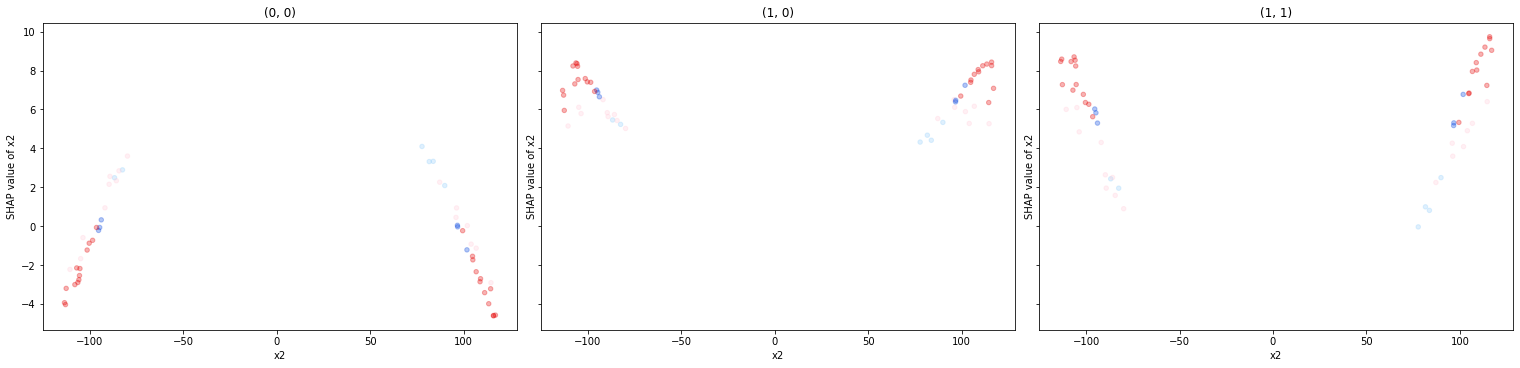

In [88]:
for feature in feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature_dependence(feature, focus=node, alpha=0.3)

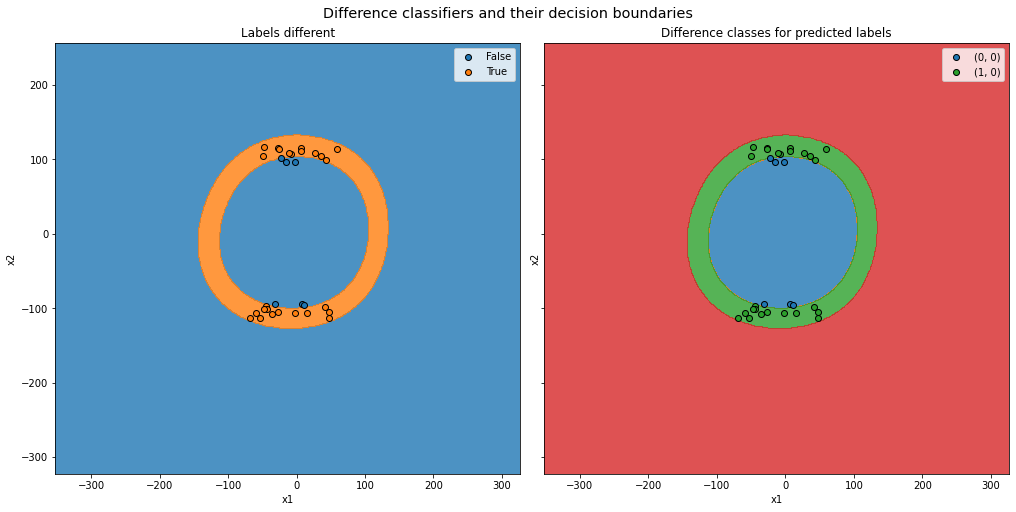

In [76]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

In [77]:
node = node.get_left()
node.class_counts, node.distance

((1, 0)    14
 dtype: int64,
 33.41587069791697)

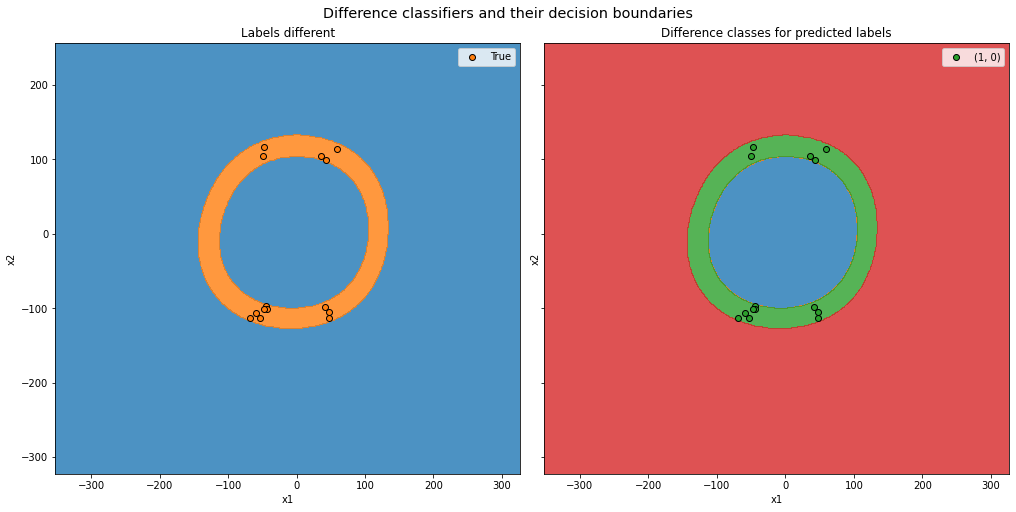

In [78]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

In [79]:
node = node.get_left()
node.class_counts, node.distance

((1, 0)    7
 dtype: int64,
 6.731275958931217)

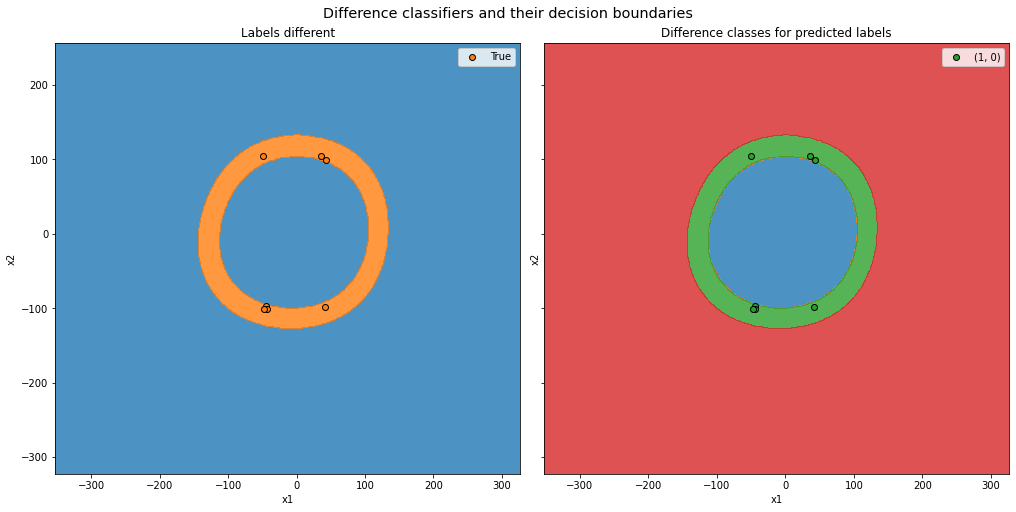

In [80]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

In [81]:
node = node.get_left()
node.class_counts, node.distance

((1, 0)    2
 dtype: int64,
 0.4731605350118516)

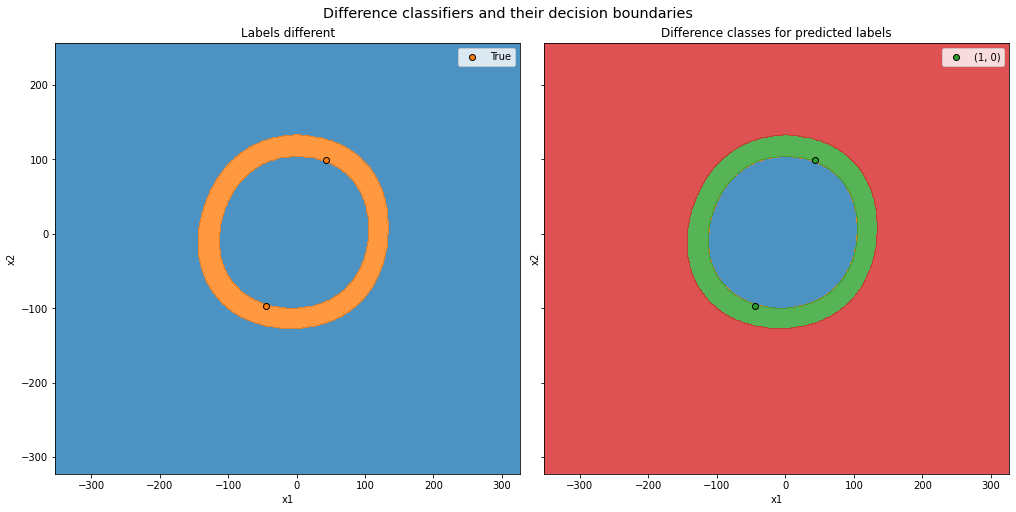

In [82]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

We can see, that even at this level, instances from the upper part of the ring and the lower part are not split. This might be the main drawback of this method. The reason is, that the clustering algorithm is based on the SHAP Values only. It does not enable splitting across original feature values. So we are getting an incomplete explanation for this type of difference.

### Node RLLRL

In [14]:
node = node.root.get('RLLR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLLRL,
 (1, 1)    19
 (1, 0)     9
 dtype: int64,
 129.13130401387397)

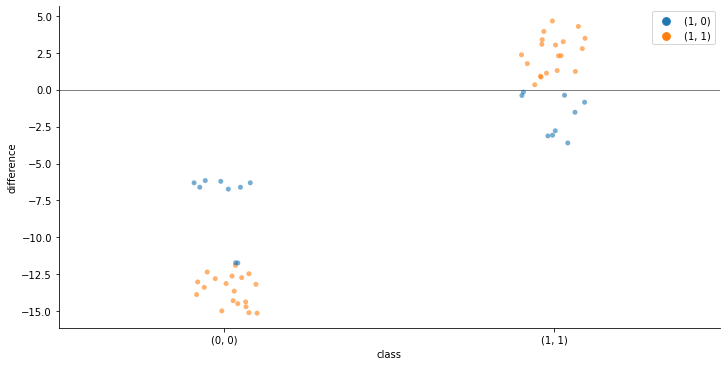

{'(0, 0)': '-11.73 to -6.15', '(1, 1)': '-3.61 to -0.16'}


In [15]:
node.plot_outcome_differences()

-29.45259350592438 <= x1 <= 27.526727519220668
x1 <= -61.0 --> {'(1, 1)': 9}
x1 >= 56.0 --> {'(1, 1)': 9}


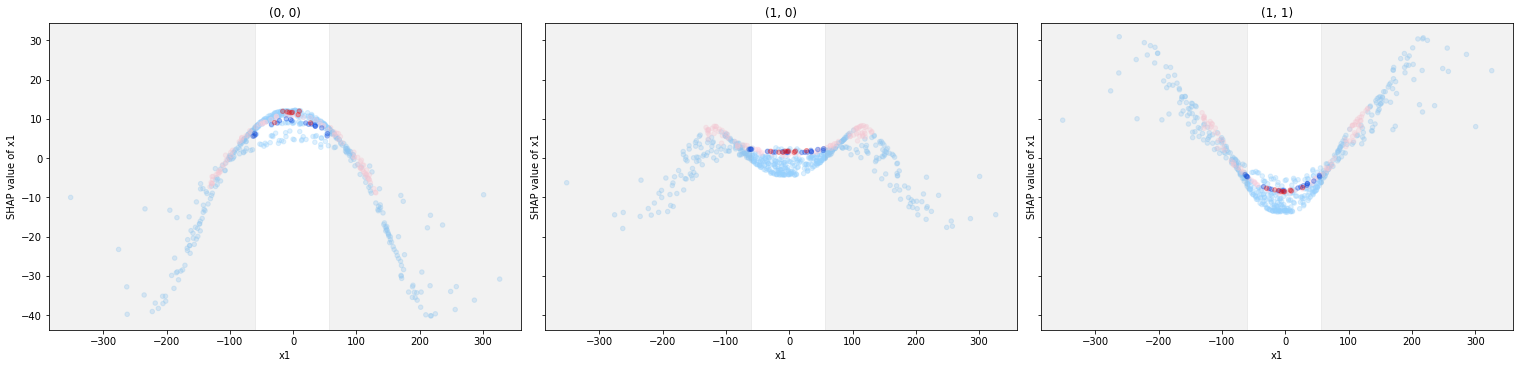

-126.41356491347094 <= x2 <= 129.7495758596666
x2 <= -128.0 --> {'(1, 1)': 9}
x2 >= 133.0 --> {'(1, 1)': 9}


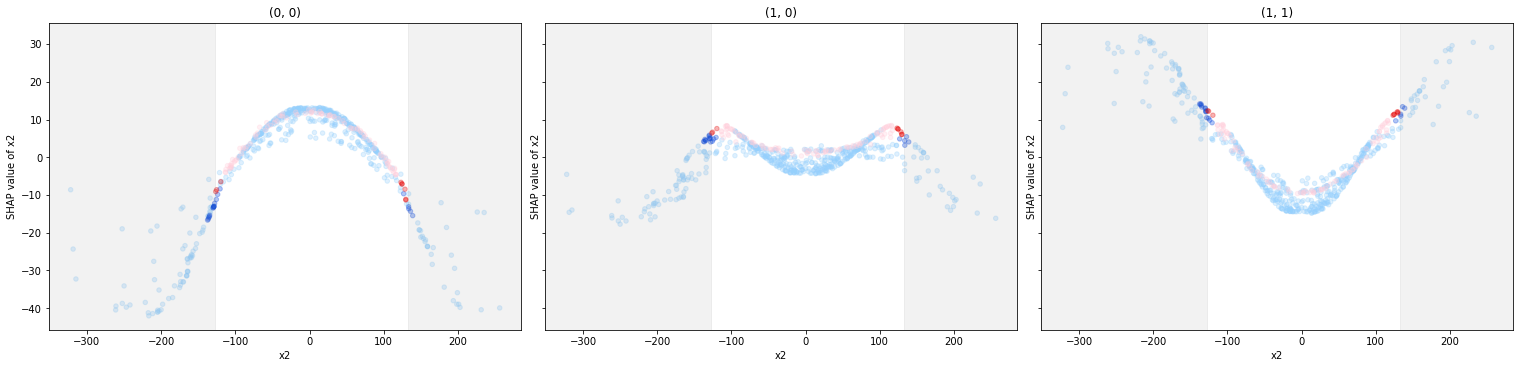

In [16]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.3)

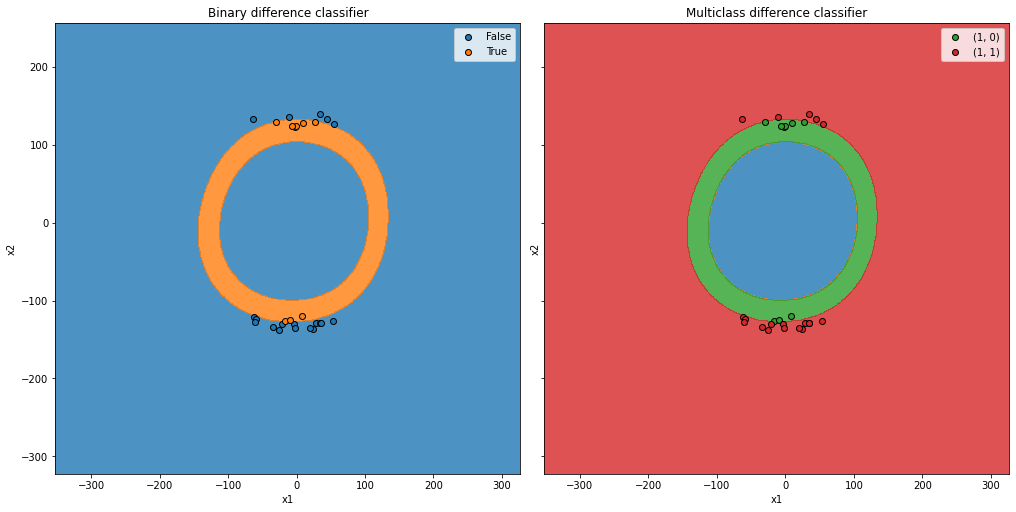

In [17]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

### Node RLRR

In [18]:
node = node.root.get('RLR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRR,
 (0, 0)    62
 (1, 0)    51
 (1, 1)    20
 dtype: int64,
 949.6286373704477)

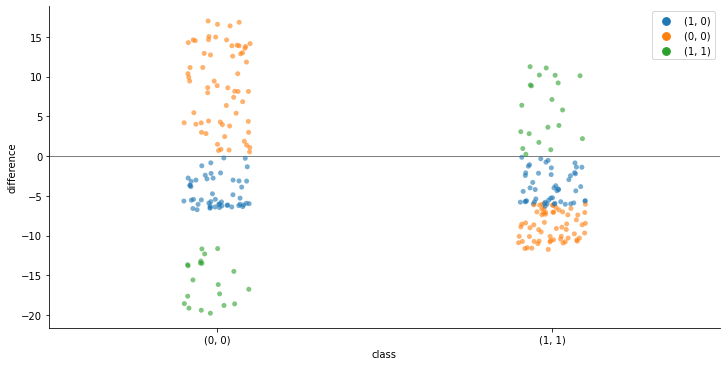

{'(0, 0)': '-6.74 to -0.23', '(1, 1)': '-6.29 to -0.15'}


In [26]:
node.plot_outcome_differences()

-131.33844202155564 <= x1 <= 130.61962226695064
x1 <= -144.0 --> {'(1, 1)': 51}
x1 >= 135.0 --> {'(1, 1)': 51}


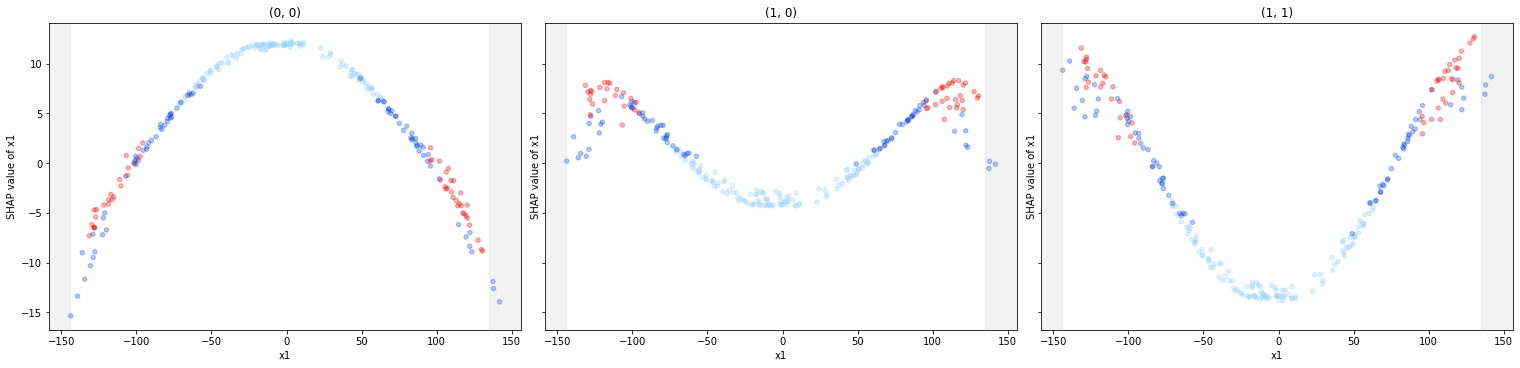

-93.91635868328355 <= x2 <= 87.70368295639693
x2 <= -104.0 --> {'(1, 1)': 51}
x2 >= 101.0 --> {'(1, 1)': 51}


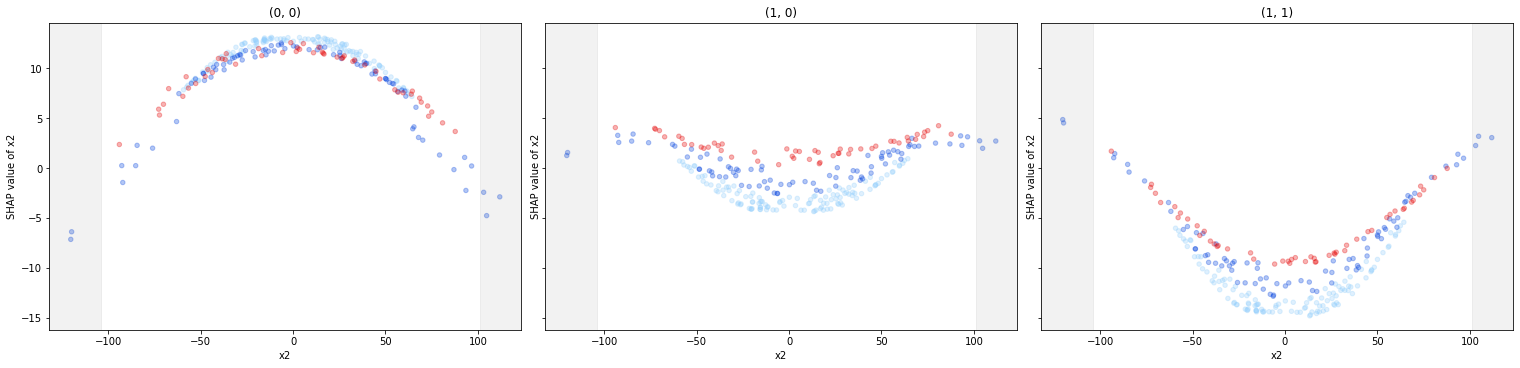

In [92]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature_dependence(feature, focus=node, alpha=0.3)

-131.33844202155564 <= x1 <= 130.61962226695064
x1 <= -144.0 --> {'(1, 1)': 51}
x1 >= 135.0 --> {'(1, 1)': 51}


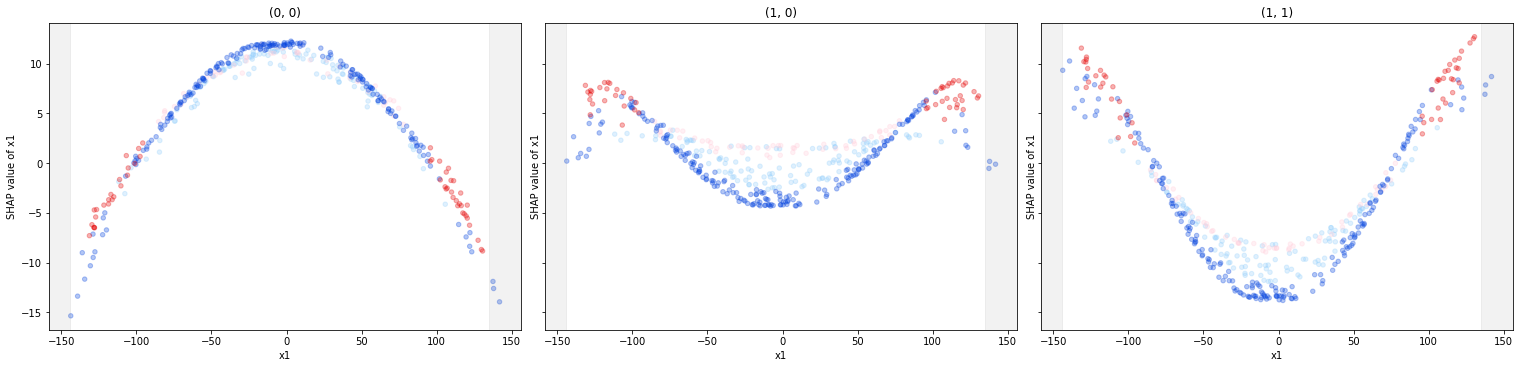

-93.91635868328355 <= x2 <= 87.70368295639693
x2 <= -104.0 --> {'(1, 1)': 51}
x2 >= 101.0 --> {'(1, 1)': 51}


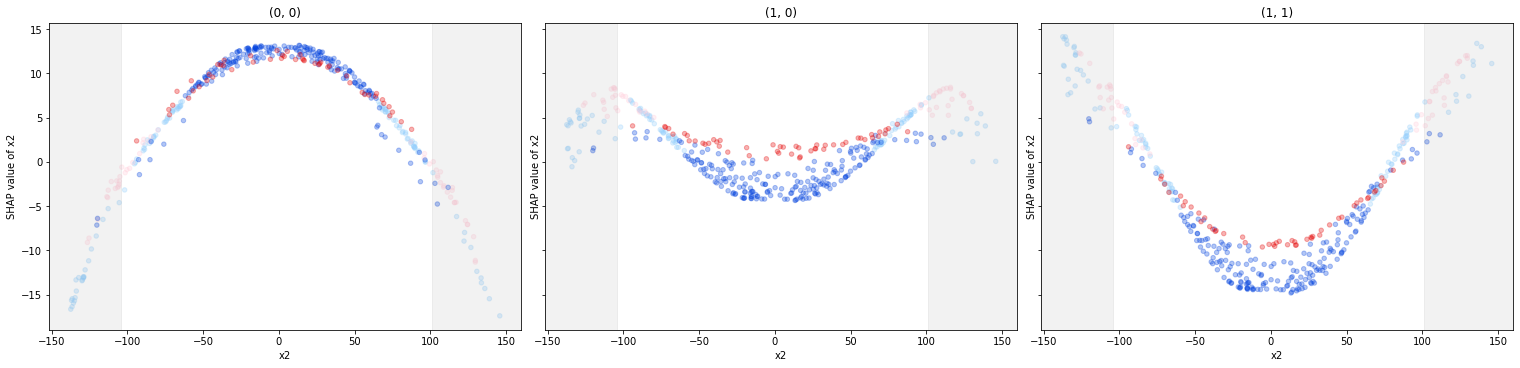

In [93]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature_dependence(feature, focus=node.parent, alpha=0.3)

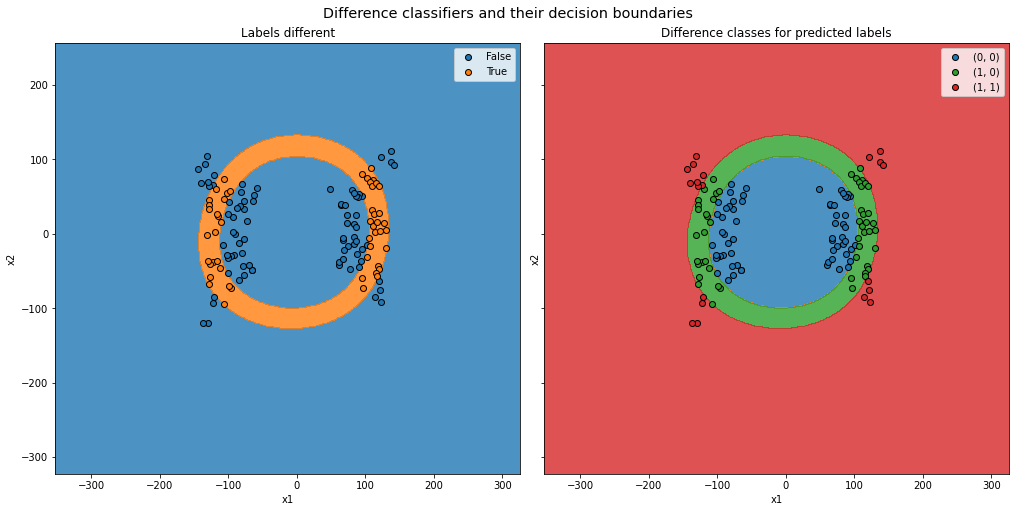

In [148]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

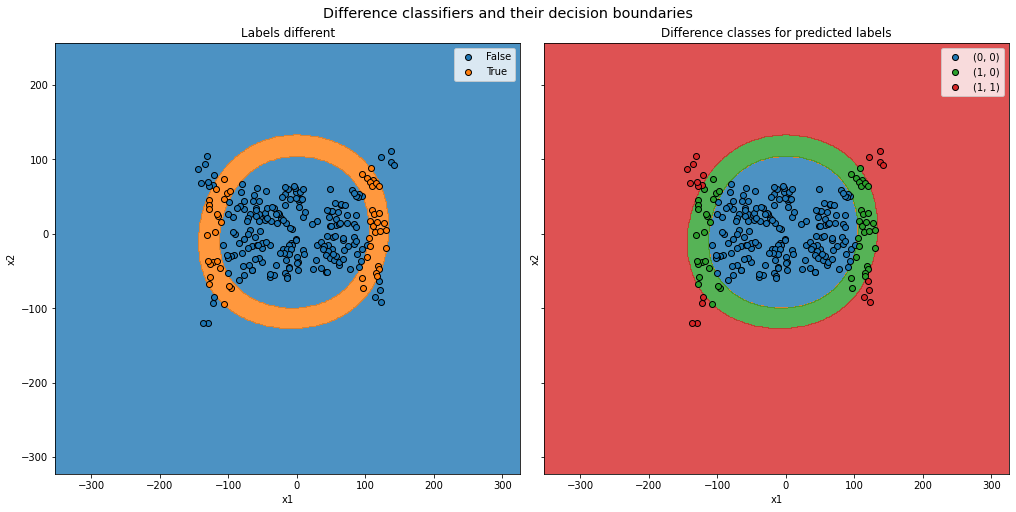

In [139]:
comparer.plot_decision_boundaries(node.parent.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

Locally, the effects are different on the log odds outcome of $(1,0)$ and $(1,1)$ than in neighboring clusters.

I stop at this level, because lower level clusters again would do not provide more insights.

### Node RLRRLL

In [19]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.distance, node.class_counts

(RLRRLL,
 165.1293877424797,
 (1, 0)    17
 (0, 0)     7
 dtype: int64)

-111.22358768774352 <= x1 <= 116.03086492129144
x1 <= -139.0 --> {'(1, 1)': 17}
x1 >= 130.0 --> {'(1, 1)': 17}


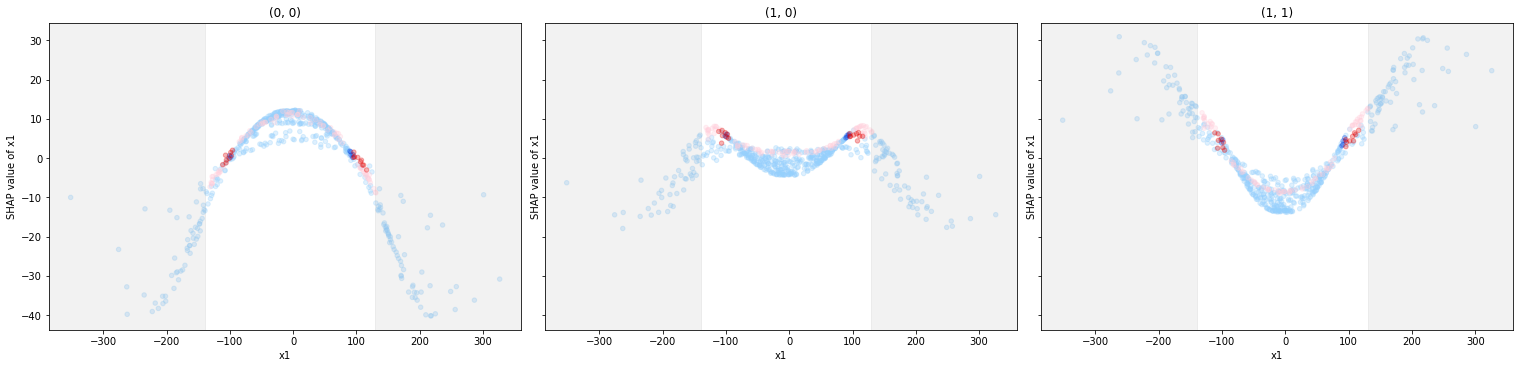

-93.91635868328355 <= x2 <= 87.70368295639693
x2 <= -104.0 --> {'(1, 1)': 17}
x2 >= 101.0 --> {'(1, 1)': 17}


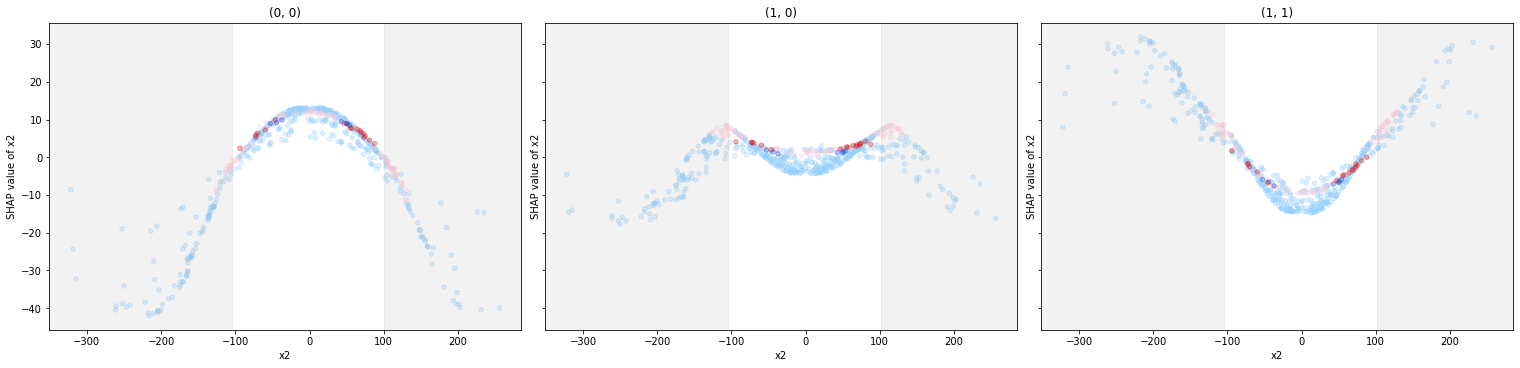

In [20]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.3)

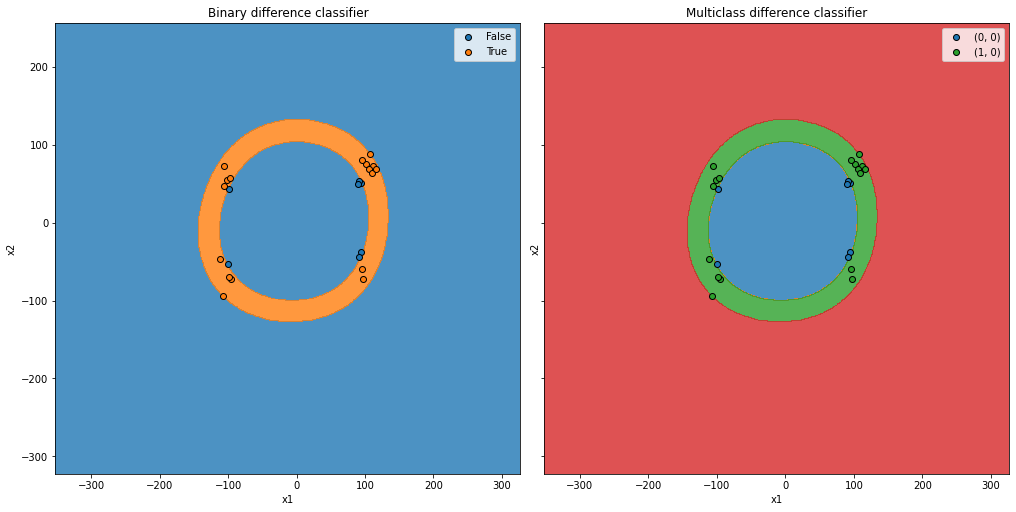

In [21]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)

### Node RLRRRL

In [22]:
node = node.root.get('RLRRR').get_last_child_before_diff_class_split()
node, node.distance, node.class_counts

(RLRRRL,
 100.10328889988827,
 (1, 0)    34
 (0, 0)     2
 dtype: int64)

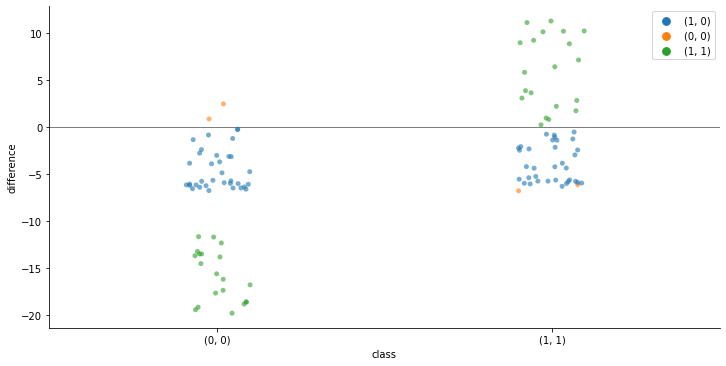

{'(0, 0)': '-6.74 to -0.23', '(1, 1)': '-6.29 to -0.53'}


In [26]:
node.parent.plot_outcome_differences()

-131.33844202155564 <= x1 <= 130.61962226695064
x1 <= -144.0 --> {'(1, 1)': 34}
x1 >= 135.0 --> {'(1, 1)': 34}


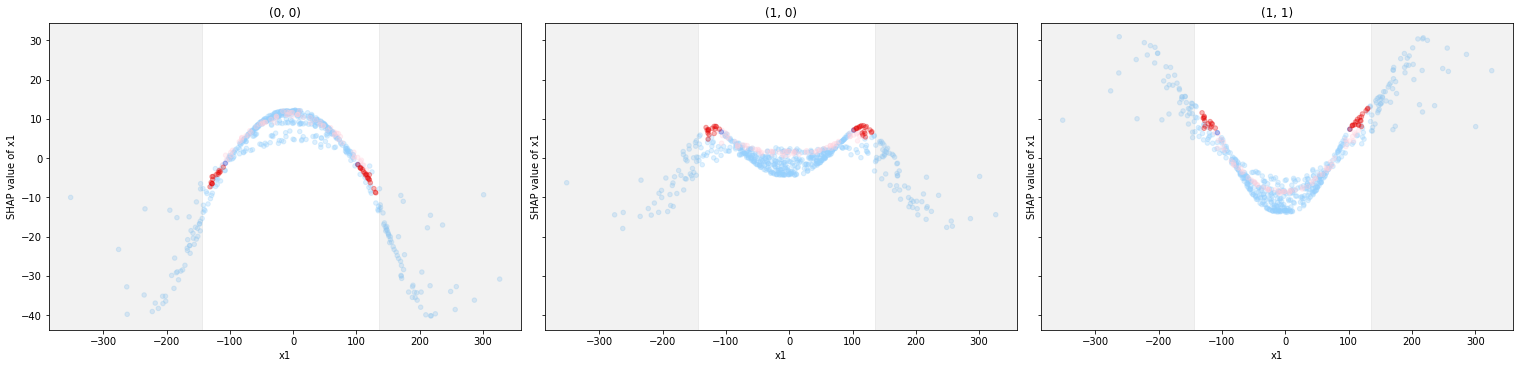

-67.24326704728615 <= x2 <= 64.52053070269106
x2 <= -92.0 --> {'(1, 1)': 34}
x2 >= 94.0 --> {'(1, 1)': 34}


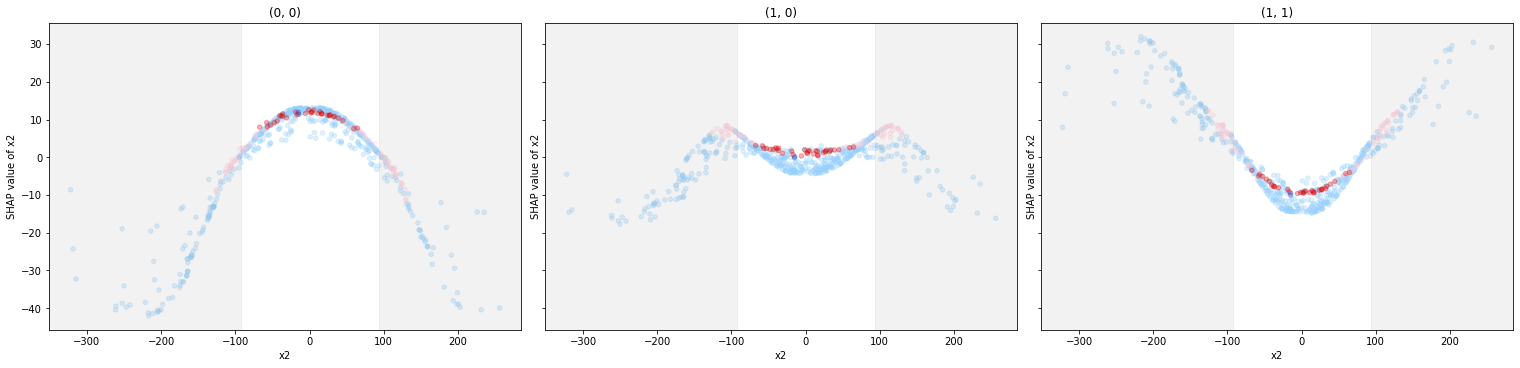

In [23]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.3)

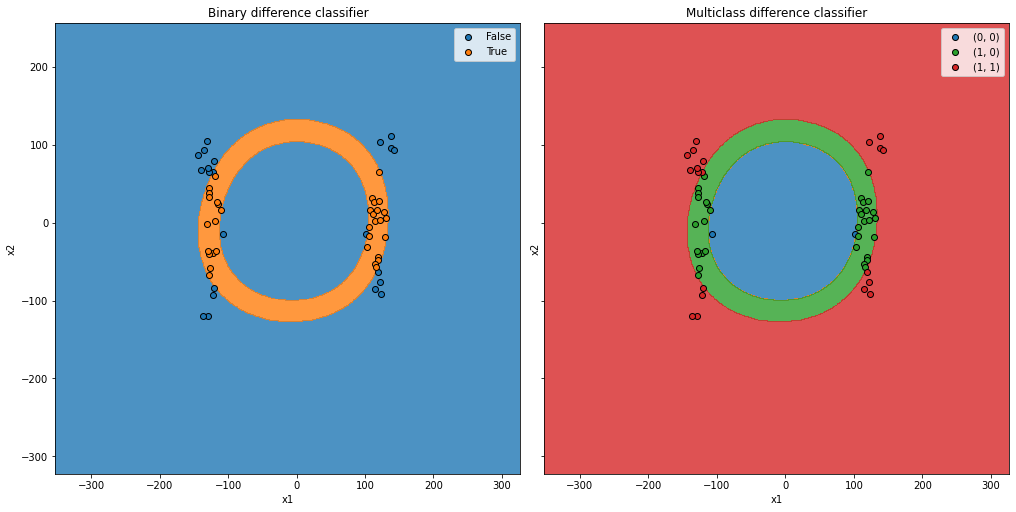

In [27]:
comparer.plot_decision_boundaries(node.parent.shap_values.data, xlim=xlim, ylim=ylim, mesh_step_size=1)